In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
==============================linear-fstw
(20, 4, 4)


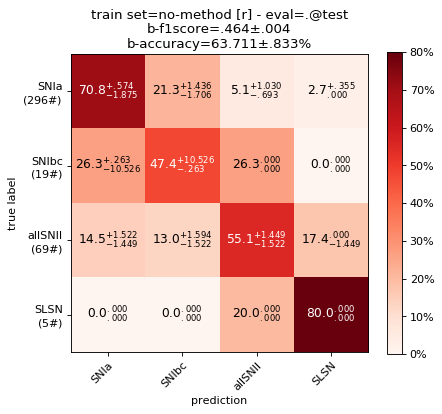

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1526
[2#] SPM_tau_rise_r=.1347
[3#] SPM_gamma_r=.1337
[4#] SPM_gamma_g=.0944
[5#] SPM_tau_rise_g=.0829
[6#] SPM_tau_fall_g=.0820
[7#] SPM_tau_fall_r=.0813
[8#] SPM_t0_r=.0773
[9#] SPM_chi_r=.0455
[10#] SPM_A_r=.0407
(20, 4, 4)


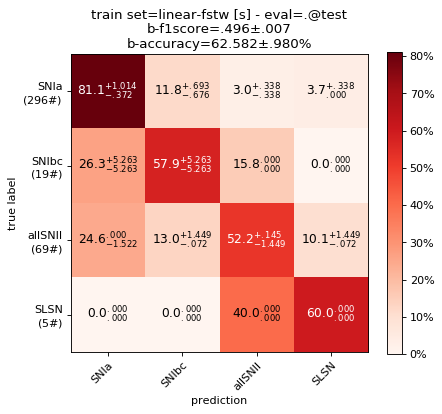

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.2125
[2#] SPM_tau_rise_r=.1303
[3#] SPM_tau_fall_r=.0835
[4#] SPM_gamma_r=.0819
[5#] SPM_tau_fall_g=.0804
[6#] SPM_gamma_g=.0776
[7#] SPM_t0_r=.0702
[8#] SPM_A_g=.0650
[9#] SPM_A_r=.0621
[10#] SPM_tau_rise_g=.0532
(20, 4, 4)


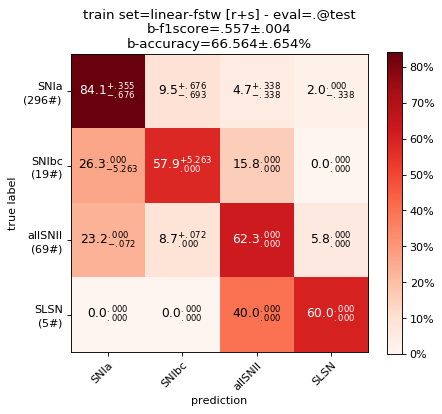

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.2082
[2#] SPM_tau_rise_r=.1261
[3#] SPM_gamma_r=.0955
[4#] SPM_tau_fall_r=.0921
[5#] SPM_tau_fall_g=.0824
[6#] SPM_gamma_g=.0792
[7#] SPM_A_r=.0652
[8#] SPM_A_g=.0583
[9#] SPM_t0_r=.0566
[10#] SPM_tau_rise_g=.0565
==============================bspline-fstw
(20, 4, 4)


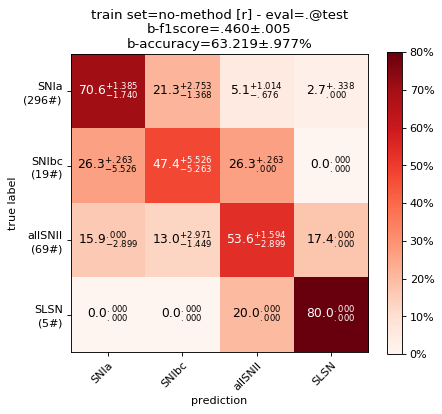

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1563
[2#] SPM_tau_rise_r=.1397
[3#] SPM_gamma_r=.1378
[4#] SPM_gamma_g=.0923
[5#] SPM_tau_fall_r=.0854
[6#] SPM_tau_rise_g=.0779
[7#] SPM_tau_fall_g=.0761
[8#] SPM_t0_r=.0733
[9#] SPM_chi_r=.0442
[10#] SPM_A_r=.0407
(20, 4, 4)


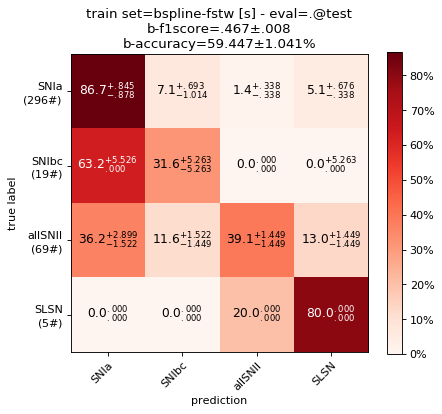

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.2032
[2#] SPM_tau_rise_r=.1377
[3#] SPM_A_g=.0773
[4#] SPM_t0_r=.0757
[5#] SPM_A_r=.0750
[6#] SPM_gamma_g=.0740
[7#] SPM_tau_fall_r=.0704
[8#] SPM_gamma_r=.0685
[9#] SPM_tau_fall_g=.0635
[10#] SPM_tau_rise_g=.0580
(20, 4, 4)


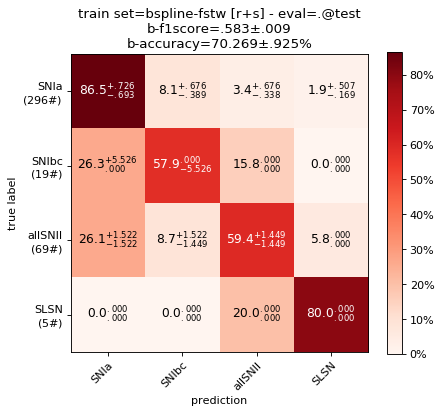

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1966
[2#] SPM_tau_rise_r=.1451
[3#] SPM_gamma_g=.0806
[4#] SPM_gamma_r=.0798
[5#] SPM_A_r=.0770
[6#] SPM_tau_fall_g=.0765
[7#] SPM_tau_fall_r=.0700
[8#] SPM_A_g=.0669
[9#] SPM_tau_rise_g=.0625
[10#] SPM_t0_r=.0593
==============================spm-mcmc-fstw
(20, 4, 4)


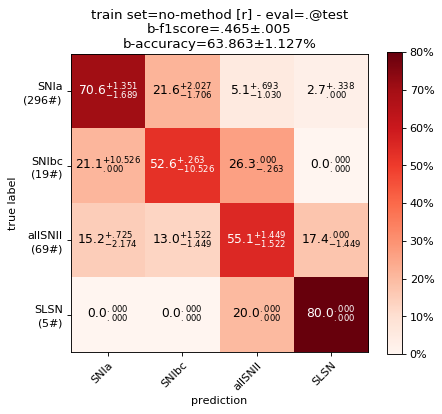

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1542
[2#] SPM_tau_rise_r=.1398
[3#] SPM_gamma_r=.1302
[4#] SPM_gamma_g=.0978
[5#] SPM_tau_fall_r=.0847
[6#] SPM_tau_rise_g=.0789
[7#] SPM_tau_fall_g=.0757
[8#] SPM_t0_r=.0741
[9#] SPM_chi_r=.0448
[10#] SPM_A_r=.0424
(20, 4, 4)


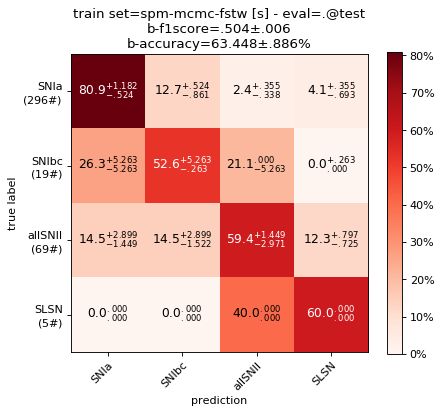

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1591
[2#] SPM_tau_rise_r=.1291
[3#] SPM_gamma_r=.1181
[4#] SPM_t0_r=.0968
[5#] SPM_tau_fall_r=.0936
[6#] SPM_A_r=.0743
[7#] SPM_tau_fall_g=.0684
[8#] SPM_A_g=.0614
[9#] SPM_gamma_g=.0600
[10#] SPM_tau_rise_g=.0529
(20, 4, 4)


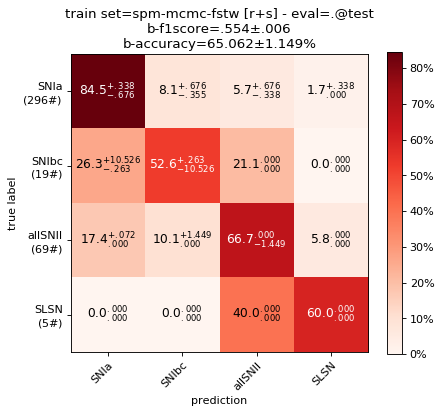

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1793
[2#] SPM_tau_rise_r=.1339
[3#] SPM_gamma_r=.1245
[4#] SPM_tau_fall_r=.0971
[5#] SPM_tau_fall_g=.0734
[6#] SPM_A_r=.0702
[7#] SPM_gamma_g=.0680
[8#] SPM_t0_r=.0623
[9#] SPM_tau_rise_g=.0565
[10#] SPM_A_g=.0553
==============================spm-mcmc-estw
(20, 4, 4)


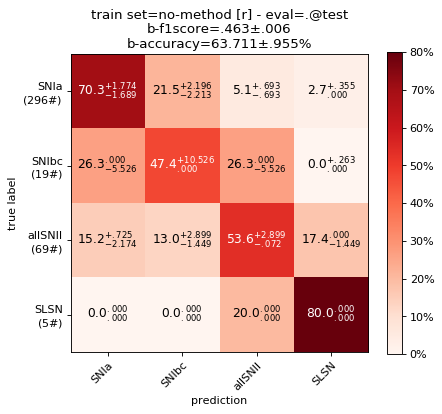

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1543
[2#] SPM_tau_rise_r=.1357
[3#] SPM_gamma_r=.1339
[4#] SPM_gamma_g=.1006
[5#] SPM_tau_fall_r=.0837
[6#] SPM_tau_rise_g=.0807
[7#] SPM_tau_fall_g=.0764
[8#] SPM_t0_r=.0709
[9#] SPM_chi_r=.0470
[10#] SPM_A_r=.0404
(20, 4, 4)


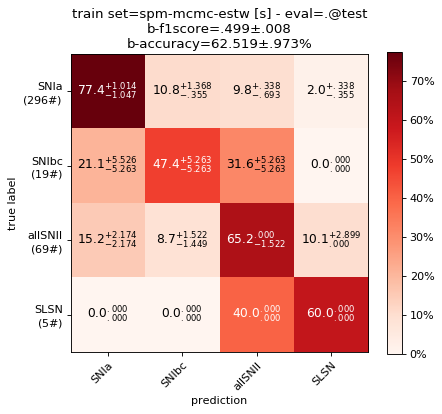

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_gamma_r=.1786
[2#] SPM_tau_rise_r=.1383
[3#] SPM_t0_g=.1177
[4#] SPM_tau_fall_r=.0836
[5#] SPM_tau_rise_g=.0782
[6#] SPM_A_r=.0745
[7#] SPM_t0_r=.0643
[8#] SPM_gamma_g=.0639
[9#] SPM_tau_fall_g=.0594
[10#] SPM_A_g=.0567
(9, 4, 4)


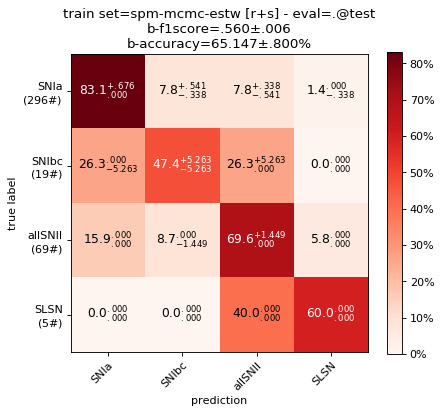

['SLSN', 'SNIa', 'SNIbc', 'allSNII']
features:
[1#] SPM_t0_g=.1639
[2#] SPM_gamma_r=.1480
[3#] SPM_tau_rise_r=.1299
[4#] SPM_tau_fall_r=.0946
[5#] SPM_gamma_g=.0747
[6#] SPM_tau_rise_g=.0669
[7#] SPM_A_r=.0656
[8#] SPM_tau_fall_g=.0654
[9#] SPM_t0_r=.0572
[10#] SPM_A_g=.0549


In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

methods = [
    'linear-fstw',
    'bspline-fstw',
    #'spm-mle-fstw',
    'spm-mcmc-fstw',
    #'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test' # val test
kf = '.'

for method in methods:
    print('='*30+method)
    #for train_config in ['r', 's']:
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        f1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])
        accuracy_xe = XError([f()['metrics_dict']['b-accuracy'] for f in files])
        print(cms.shape)

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'train set={_title} - eval={kf}@{eval_lcset_name}'+'\n'
        title += f'b-f1score={f1score_xe}'+'\n'
        title += f'b-accuracy={accuracy_xe}%'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'allSNII', 'SLSN'],
        }
        fig, ax = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #print(files[0]()['features'])
        plt.show()
        print(class_names)
        print(files[0]()['rank'])
        df = files[0]()['wrongs_df']
        #display(df[df['_y']==0])
        #display(df[df['_y']==2])

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

metrics = [
    'b-accuracy',
    'b-f1score',
    'b-gmean',
    #'b-dpower',
    'b-xentropy',
]
info_df = DFBuilder()
for metric in metrics:
    for train_config in ['r', 's', 'r+s']:
    #for train_config in ['r', 's']:
        d = {}
        for method in methods:
            rootdir = f'../save/exp=rf_eval~train_config={train_config}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            metric_xe = XError([f()['metrics_dict'][metric] for f in files])
            d[method] = metric_xe
            #print(len(metric_xe))

        info_df.append(f'metric={metric} [{train_config}]', d)
        
latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
print('% \multicolumn{3}{c|}{}')
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|ccc|c}
\hline
metric & linear-fstw & bspline-fstw & spm-mcmc-fstw & spm-mcmc-estw \srule\\\hline\hline
b-accuracy [r] & 58.812$\pm$4.668 & 57.567$\pm$3.607 & 59.543$\pm$4.724 & 58.548$\pm$3.555  \srule\\
b-accuracy [s] & 62.396$\pm$6.646 & 44.508$\pm$6.186 & 59.162$\pm$8.667 & 57.032$\pm$10.742  \srule\\
b-accuracy [r+s] & 57.671$\pm$5.745 & 51.521$\pm$4.467 & 50.509$\pm$4.430 & 57.254$\pm$5.129  \srule\\
\hline
b-f1score [r] & .421$\pm$.055 & .423$\pm$.048 & .415$\pm$.060 & .447$\pm$.035  \srule\\
b-f1score [s] & .521$\pm$.068 & .353$\pm$.053 & .498$\pm$.078 & .493$\pm$.084  \srule\\
b-f1score [r+s] & .500$\pm$.055 & .455$\pm$.073 & .474$\pm$.038 & .525$\pm$.0

,linear-fstw,bspline-fstw,spm-mcmc-fstw,spm-mcmc-estw
metric=b-accuracy [r],58.812±4.668,57.567±3.607,59.543±4.724,58.548±3.555
metric=b-accuracy [s],62.396±6.646,44.508±6.186,59.162±8.667,57.032±10.742
metric=b-accuracy [r+s],57.671±5.745,51.521±4.467,50.509±4.430,57.254±5.129
metric=b-f1score [r],.421±.055,.423±.048,.415±.060,.447±.035
metric=b-f1score [s],.521±.068,.353±.053,.498±.078,.493±.084
metric=b-f1score [r+s],.500±.055,.455±.073,.474±.038,.525±.062
metric=b-gmean [r],.693±.053,.689±.044,.700±.048,.706±.026
metric=b-gmean [s],.736±.055,.564±.080,.700±.088,.671±.114
metric=b-gmean [r+s],.672±.076,.623±.037,.605±.076,.680±.071
metric=b-xentropy [r],1.084±.042,1.111±.019,1.094±.031,1.072±.039


In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 's' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        rank = files[0]()['rank']
        #print(rank)
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.3f}%)'

    info_df.append(f'rank={k+1}', d)

latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|ccc|c}
\hline
rank & linear-fstw [s] & bspline-fstw [s] & spm-mcmc-fstw [s] & spm-mcmc-estw [s] \srule\\\hline\hline
1 & SPM-t0-g (15.958\%) & Amplitude-g (10.661\%) & SPM-t0-g (10.418\%) & SPM-gamma-r (11.953\%)  \srule\\
2 & SPM-tau-rise-r (7.567\%) & SPM-t0-g (9.531\%) & SPM-gamma-r (7.040\%) & SPM-tau-rise-r (7.226\%)  \srule\\
3 & LinearTrend-g (5.436\%) & SPM-tau-rise-r (7.262\%) & SPM-tau-rise-r (6.751\%) & SPM-t0-g (7.111\%)  \srule\\
4 & SPM-beta-r (5.000\%) & ExcessVar-r (3.416\%) & SPM-beta-r (6.382\%) & SPM-beta-r (5.678\%)  \srule\\
5 & SPM-tau-fall-r (3.819\%) & MHPS-ratio-g (2.762\%) & LinearTrend-g (6.305\%) & FluxPercentileRatioMid50-r (4.309\%

,linear-fstw [s],bspline-fstw [s],spm-mcmc-fstw [s],spm-mcmc-estw [s]
rank=1,SPM-t0-g (15.958%),Amplitude-g (10.661%),SPM-t0-g (10.418%),SPM-gamma-r (11.953%)
rank=2,SPM-tau-rise-r (7.567%),SPM-t0-g (9.531%),SPM-gamma-r (7.040%),SPM-tau-rise-r (7.226%)
rank=3,LinearTrend-g (5.436%),SPM-tau-rise-r (7.262%),SPM-tau-rise-r (6.751%),SPM-t0-g (7.111%)
rank=4,SPM-beta-r (5.000%),ExcessVar-r (3.416%),SPM-beta-r (6.382%),SPM-beta-r (5.678%)
rank=5,SPM-tau-fall-r (3.819%),MHPS-ratio-g (2.762%),LinearTrend-g (6.305%),FluxPercentileRatioMid50-r (4.309%)
rank=6,SPM-tau-fall-g (3.729%),Amplitude-r (2.728%),SPM-t0-r (4.738%),SPM-tau-fall-r (3.696%)
rank=7,SPM-gamma-r (3.149%),SPM-gamma-r (2.431%),SPM-tau-fall-r (4.678%),SPM-tau-rise-g (3.430%)
rank=8,SPM-gamma-g (2.827%),MHPS-high-g (2.286%),SPM-tau-fall-g (2.387%),SmallKurtosis-g (3.347%)
rank=9,Meanvariance-r (2.212%),SPM-gamma-g (2.246%),Meanvariance-r (2.132%),SPM-t0-r (2.418%)
rank=10,LinearTrend-r (1.883%),SPM-t0-r (2.191%),SPM-gamma-g (1.594%),SPM-tau-fall-g (1.936%)
